# Classification for Custom Images

이번 실습에서는 Keras에 내장된 data가 아닌 외부에서 가져온 image data를 이용하여 classification 실습을 해보겠습니다.


## Oxford-IIIT Pet Dataset 준비

- dataset은 아래 주소에서 받으실 수 있습니다   
https://drive.google.com/file/d/1dIR9ANjUsV9dWa0pS9J0c2KUGMfpIRG0

- 원본 data는 아래 경로에서 받을 수 있습니다.  
https://www.robots.ox.ac.uk/~vgg/data/pets/

이 dataset은 고양이와 개 총 37종류의 image(class별 약 200장)와 각 image에 대한 class정보, 머리 위치에 대한 Bounding box 정보, 그리고 image segmentation map과 몇가지 추가 정보로 구성되어 있습니다.


<참고> 본인의 google drive와 연동하여 google drive 내에 file을 download할 수도 있으나, 속도가 느려지는 단점이 있어서 이번 실습에서는 colab 서버 내에 data를 download하는 방식으로 진행합니다.

In [1]:
## Google Colab에서 TensorFlow 2.x 버전을 사용하기 위해서는 아래 magic command를 수행하면 간편하게 할 수 있습니다

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

TensorFlow 2.x selected.


In [2]:
## library import
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
from PIL import Image
import shutil
from sklearn.model_selection import train_test_split
import random
import matplotlib.pyplot as plt

print(tf.__version__)
print(keras.__version__)

2.1.0
2.2.4-tf


In [3]:
## google drive에서 압축된 dataset download
import gdown
url = 'https://drive.google.com/uc?id=1dIR9ANjUsV9dWa0pS9J0c2KUGMfpIRG0'
fname = 'oxford_pet.zip'
gdown.download(url, fname, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1dIR9ANjUsV9dWa0pS9J0c2KUGMfpIRG0
To: /content/oxford_pet.zip
811MB [00:18, 43.5MB/s]


'oxford_pet.zip'

In [4]:
## oxford_pet.zip이 보이는지 확인
!ls -l

total 791576
-rw-r--r-- 1 root root 810565619 Mar 13 17:47 oxford_pet.zip
drwxr-xr-x 1 root root      4096 Mar  3 18:11 sample_data


In [0]:
## 압축풀기
!unzip -q oxford_pet.zip -d oxford_pet

In [6]:
## 압축이 풀린 directory 확인
!ls oxford_pet

## annotations directory 내에는 segmentation map(trimaps), localization bounding box 위치정보(xmls) 등이 들어 있습니다.
## images directory 내에는 개와 고양이 사진들이 들어 있습니다.

annotations  images


### 개 / 고양이 2-class classification을 위한 Data 준비

In [0]:
## directory 설정
cur_dir = os.getcwd()
data_dir = os.path.join(cur_dir, 'oxford_pet')
image_dir = os.path.join(data_dir, 'images')

In [8]:
## image file 수 확인
image_files = [fname for fname in os.listdir(image_dir) if os.path.splitext(fname)[-1] == '.jpg']
print(len(image_files))

7390


In [9]:
## image file들을 읽어서 channel이 3이 아닌 image는 삭제
for image_file in image_files:
  image_path = os.path.join(image_dir, image_file)
  image = Image.open(image_path)
  image_mode = image.mode
  if image_mode != 'RGB':
    print(image_file, image_mode)
    image = np.asarray(image)
    print(image.shape)
    os.remove(image_path)

Egyptian_Mau_177.jpg P
(175, 246)
Egyptian_Mau_145.jpg P
(188, 216)
Egyptian_Mau_14.jpg RGBA
(800, 582, 4)
Abyssinian_5.jpg RGBA
(150, 200, 4)
Abyssinian_34.jpg P
(202, 250)
Egyptian_Mau_139.jpg P
(250, 350)
Egyptian_Mau_191.jpg P
(214, 300)
staffordshire_bull_terrier_2.jpg L
(282, 500)
staffordshire_bull_terrier_22.jpg L
(500, 364)
Egyptian_Mau_167.jpg P
(275, 183)
Egyptian_Mau_186.jpg RGBA
(275, 183, 4)
Egyptian_Mau_129.jpg L
(325, 299)


In [0]:
## 개와 고양이 directory 생성
dog_dir = os.path.join(data_dir, 'dogs')
cat_dir = os.path.join(data_dir, 'cats')
os.makedirs(dog_dir, exist_ok=True)
os.makedirs(cat_dir, exist_ok=True)

In [0]:
## image file 중 개 이미지는 dogs 디렉토리에, 고양이 이미지는 cats 디렉토리에 복사
## file 이름의 첫 글자가 대문자로 시작하면 고양이, 소문자로 시작하면 개의 image임을 이용함

cat_cnt = 0
dog_cnt = 0
image_files = os.listdir(image_dir)
for image_file in image_files:  
  image_path = os.path.join(image_dir, image_file)
  ## file 이름의 첫글자가 소문자인지 확인: 개
  if image_file[0].islower():
    dog_cnt += 1
    copy_path = os.path.join(dog_dir, image_file)
  ## file 이름 첫글자가 대문자인 경우: 고양이
  else:
    cat_cnt += 1
    copy_path = os.path.join(cat_dir, image_file)
  ## image copy
  shutil.copy(image_path, copy_path)

In [12]:
print("총 복사된 image 수: {}".format(dog_cnt+cat_cnt))
print("개 image 수: {}".format(dog_cnt))
print("고양이 image 수: {}".format(cat_cnt))

총 복사된 image 수: 7378
개 image 수: 4988
고양이 image 수: 2390


In [0]:
## train data와 test data를 나누기 위한 디렉토리 생성
train_dir = os.path.join(data_dir, 'train_images')
train_dog_dir = os.path.join(train_dir, 'dogs')
train_cat_dir = os.path.join(train_dir, 'cats')

test_dir = os.path.join(data_dir, 'test_images')
test_dog_dir = os.path.join(test_dir, 'dogs')
test_cat_dir = os.path.join(test_dir, 'cats')

os.makedirs(train_dir, exist_ok=True)
os.makedirs(train_dog_dir, exist_ok=True)
os.makedirs(train_cat_dir, exist_ok=True)

os.makedirs(test_dir, exist_ok=True)
os.makedirs(test_dog_dir, exist_ok=True)
os.makedirs(test_cat_dir, exist_ok=True)

In [14]:
## cats 디렉토리에서 random하게 2000장은 train 디렉토리로, 나머지는 test 디렉토리로 복사
cat_files = os.listdir(cat_dir)
rnd_idx = random.sample(range(len(cat_files)), len(cat_files))
test_idx = rnd_idx[2000:]
train_cnt = 0
test_cnt = 0
for idx, cat_file in enumerate(cat_files):
  cat_path = os.path.join(cat_dir, cat_file)
  if idx in test_idx:
    test_cnt += 1
    shutil.copy(cat_path, test_cat_dir)
  else:
    train_cnt += 1
    shutil.copy(cat_path, train_cat_dir)

print("train image 수: {}".format(train_cnt))
print("test image 수: {}".format(test_cnt))

train image 수: 2000
test image 수: 390


In [15]:
## 개 image가 더 많으므로 고양이 image 수에 맞추어 randome하게 2390장을 뽑아서 그 중 2000장은 train, 390장으 test 디렉토리로 복사
dog_files = os.listdir(dog_dir)
rnd_idx = random.sample(range(len(dog_files)), len(cat_files))
train_idx = rnd_idx[:2000]
test_idx = rnd_idx[2000:]
train_cnt = 0
test_cnt = 0
for idx, dog_file in enumerate(dog_files):
  dog_path = os.path.join(dog_dir, dog_file)
  if idx in test_idx:
    test_cnt += 1
    shutil.copy(dog_path, test_dog_dir)
  elif idx in train_idx:
    train_cnt += 1
    shutil.copy(dog_path, train_dog_dir)
  else:
    continue

print("train image 수: {}".format(train_cnt))
print("test image 수: {}".format(test_cnt))

train image 수: 2000
test image 수: 390


### CNN으로 학습하기

In [0]:
## Hyper Parameters
N_EPOCHS = 20
N_TRAIN_BATCH = 40
N_VAL_BATCH = 30
N_TRAIN = 4000
N_VAL = 780
IMG_SIZE = 224
learning_rate = 0.001
steps_per_epoch = N_TRAIN / N_TRAIN_BATCH
validation_steps = N_VAL / N_VAL_BATCH

In [17]:
## Keras ImageDataGenerator를 이용하여 directory에서 image 읽고 전처리하기
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=N_TRAIN_BATCH
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=N_VAL_BATCH
)

Found 4000 images belonging to 2 classes.
Found 780 images belonging to 2 classes.


In [0]:
# Sequential API를 사용하여 model 구성
def create_model():
    model = keras.Sequential()
    model.add(keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='SAME', 
                                  input_shape=(IMG_SIZE, IMG_SIZE, 3)))
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    model.add(keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='SAME'))
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    model.add(keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='SAME'))
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(256, activation='relu'))
    model.add(keras.layers.Dropout(0.4))
    model.add(keras.layers.Dense(2, activation='softmax'))
    return model

In [19]:
## Create model, compile & summary
model = create_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0

In [20]:
history = model.fit_generator(
    train_generator,
    epochs=N_EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_data=test_generator,
    validation_steps=validation_steps
)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 100.0 steps, validate for 26.0 steps
Epoch 1/20
100/100 [==============================] - 35s 353ms/step - loss: 0.7398 - accuracy: 0.5410 - val_loss: 0.6616 - val_accuracy: 0.6103
Epoch 2/20
100/100 [==============================] - 29s 287ms/step - loss: 0.6306 - accuracy: 0.6442 - val_loss: 0.6333 - val_accuracy: 0.6641
Epoch 3/20
100/100 [==============================] - 28s 285ms/step - loss: 0.5452 - accuracy: 0.7268 - val_loss: 0.5840 - val_accuracy: 0.7128
Epoch 4/20
100/100 [==============================] - 29s 285ms/step - loss: 0.4373 - accuracy: 0.7940 - val_loss: 0.6182 - val_accuracy: 0.7051
Epoch 5/20
100/100 [==============================] - 29s 285ms/step - loss: 0.3254 - accuracy: 0.8615 - val_loss: 0.5994 - val_accuracy: 0.7333
Epoch 6/20
100/100 [==============================] - 29s 288ms/step - loss: 0.2223 - accuracy: 0.9118

## Pretrained MobileNet으로 학습하기

In [0]:
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input, decode_predictions

In [22]:
## Pretrained MobileNet 가져오기
mobilenet = MobileNet(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

17227776/17225924 [==============================] - 1s 0us/step


In [0]:
## Model 만들기
from tensorflow.keras.layers import Dense, ReLU, Softmax, BatchNormalization, GlobalAveragePooling2D
def create_model():
    model = keras.Sequential()
    model.add(mobilenet)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(128))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Dense(2))
    model.add(BatchNormalization())
    model.add(Softmax())
    return model

In [40]:
## Create model, compile & summary
model = create_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Model)   (None, 7, 7, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1024)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               131200    
_________________________________________________________________
batch_normalization_4 (Batch (None, 128)               512       
_________________________________________________________________
re_lu_2 (ReLU)               (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 258       
_________________________________________________________________
batch_normalization_5 (Batch (None, 2)                

In [41]:
history = model.fit(
    train_generator,
    epochs=5,
    steps_per_epoch=steps_per_epoch,
    validation_data=test_generator,
    validation_steps=validation_steps
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 100.0 steps, validate for 26.0 steps
Epoch 1/5
100/100 [==============================] - 45s 449ms/step - loss: 0.1550 - accuracy: 0.9835 - val_loss: 0.1795 - val_accuracy: 0.9385
Epoch 2/5
100/100 [==============================] - 41s 409ms/step - loss: 0.1203 - accuracy: 0.9948 - val_loss: 0.1480 - val_accuracy: 0.9744
Epoch 3/5
100/100 [==============================] - 41s 407ms/step - loss: 0.1002 - accuracy: 0.9965 - val_loss: 0.1792 - val_accuracy: 0.9615
Epoch 4/5
100/100 [==============================] - 41s 411ms/step - loss: 0.0990 - accuracy: 0.9912 - val_loss: 0.3830 - val_accuracy: 0.8372
Epoch 5/5
100/100 [==============================] - 41s 411ms/step - loss: 0.0866 - accuracy: 0.9935 - val_loss: 0.2021 - val_accuracy: 0.9256


## TFRecord 만들기

In [0]:
## tfrecord 파일 저장할 directory 생성 및 파일 경로 설정
tfr_dir = os.path.join(data_dir, 'tfrecord')
os.makedirs(tfr_dir, exist_ok=True)

tfr_train_dir = os.path.join(tfr_dir, 'train.tfrecord')
tfr_test_dir = os.path.join(tfr_dir, 'test.tfrecord')

In [0]:
## tfrecord write 생성
writer_train = tf.io.TFRecordWriter(tfr_train_dir)
writer_test = tf.io.TFRecordWriter(tfr_test_dir)

In [0]:
## tfrecord file tutorial(간단버전)
with tf.io.TFRecordWriter('my_data.tfrecord') as f:
  f.write(b'This is the first record')
  f.write(b'And this is the second record')

In [29]:
dataset = tf.data.TFRecordDataset('my_data.tfrecord')
for item in dataset:
  print(item)

tf.Tensor(b'This is the first record', shape=(), dtype=string)
tf.Tensor(b'And this is the second record', shape=(), dtype=string)


In [0]:
def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))
def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))
def _bytes_feature(value):
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy()
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

In [31]:
## train data의 tfrecord file 생성
n_train = 0
## cats
cat_files = os.listdir(train_cat_dir)
for cat_file in cat_files:
  cat_path = os.path.join(train_cat_dir, cat_file)
  image = Image.open(cat_path)
  image = image.resize((IMG_SIZE, IMG_SIZE))
  bimage = image.tobytes()
  label = 0
  example = tf.train.Example(features=tf.train.Features(feature={
            'image': _bytes_feature(bimage),
            'label': _int64_feature(label)}))
  writer_train.write(example.SerializeToString())
  n_train += 1

dog_files = os.listdir(train_dog_dir)
for dog_file in dog_files:
  dog_path = os.path.join(train_dog_dir, dog_file)
  image = Image.open(dog_path)
  image = image.resize((IMG_SIZE, IMG_SIZE))
  bimage = image.tobytes()
  label = 1
  example = tf.train.Example(features=tf.train.Features(feature={
            'image': _bytes_feature(bimage),
            'label': _int64_feature(label)}))
  writer_train.write(example.SerializeToString())
  n_train += 1

print(n_train)

4000


In [32]:
## test data의 tfrecord file 생성
n_test = 0
## cats
cat_files = os.listdir(test_cat_dir)
for cat_file in cat_files:
  cat_path = os.path.join(test_cat_dir, cat_file)
  image = Image.open(cat_path)
  image = image.resize((IMG_SIZE, IMG_SIZE))
  bimage = image.tobytes()
  label = 0
  example = tf.train.Example(features=tf.train.Features(feature={
            'image': _bytes_feature(bimage),
            'label': _int64_feature(label)}))
  writer_test.write(example.SerializeToString())
  n_test += 1

dog_files = os.listdir(test_dog_dir)
for dog_file in dog_files:
  dog_path = os.path.join(test_dog_dir, dog_file)
  image = Image.open(dog_path)
  image = image.resize((IMG_SIZE, IMG_SIZE))
  bimage = image.tobytes()
  label = 1
  example = tf.train.Example(features=tf.train.Features(feature={
            'image': _bytes_feature(bimage),
            'label': _int64_feature(label)}))
  writer_test.write(example.SerializeToString())
  n_test += 1

print(n_test)

780


In [33]:
!ls -l oxford_pet/tfrecord

total 702936
-rw-r--r-- 1 root root 117456896 Mar 13 18:02 test.tfrecord
-rw-r--r-- 1 root root 602345472 Mar 13 18:02 train.tfrecord


In [0]:
## tfrecord file을 data로 parsing해주는 function
def _parse_function(tfrecord_serialized):
    features={'image': tf.io.FixedLenFeature([], tf.string),
              'label': tf.io.FixedLenFeature([], tf.int64)
             }
    parsed_features = tf.io.parse_single_example(tfrecord_serialized, features)
    
    image = tf.io.decode_raw(parsed_features['image'], tf.uint8)
    image = tf.reshape(image, [IMG_SIZE, IMG_SIZE, 3])
    image = tf.cast(image, tf.float32)/255. 

    label = tf.cast(parsed_features['label'], tf.int64)

    return image, label

In [0]:
## train dataset 만들기
train_dataset = tf.data.TFRecordDataset(tfr_train_dir)
train_dataset = train_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(buffer_size=N_TRAIN).prefetch(
    tf.data.experimental.AUTOTUNE).batch(N_TRAIN_BATCH).repeat()
train_dataset = train_dataset.apply(tf.data.experimental.ignore_errors())

In [0]:
## validation dataset 만들기
val_dataset = tf.data.TFRecordDataset(tfr_test_dir)
val_dataset = val_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.shuffle(buffer_size=N_VAL).prefetch(
    tf.data.experimental.AUTOTUNE).batch(N_VAL_BATCH).repeat()
val_dataset = val_dataset.apply(tf.data.experimental.ignore_errors())

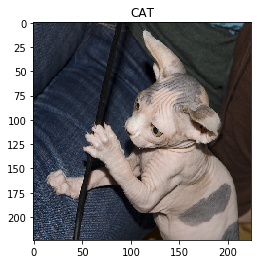

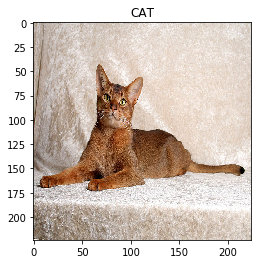

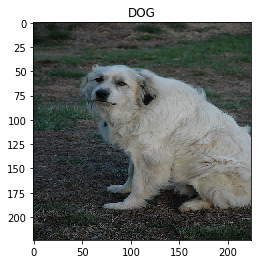

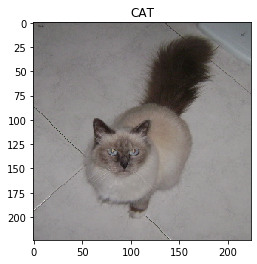

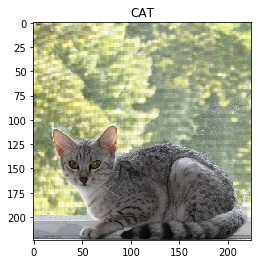

In [37]:
for image, label in train_dataset.take(5):
  plt.imshow(image[0])
  if label[0].numpy() == 0:
    plt.title('CAT')
  else:
    plt.title('DOG')  
  plt.show()

In [38]:
## Create model, compile & summary
model = create_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Model)   (None, 7, 7, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               131200    
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 258       
_________________________________________________________________
batch_normalization_3 (Batch (None, 2)                

In [39]:
history = model.fit(
    train_dataset,
    epochs=5,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset,
    validation_steps=validation_steps
)

Train for 100.0 steps, validate for 26.0 steps
Epoch 1/5
100/100 [==============================] - 47s 475ms/step - loss: 0.1590 - accuracy: 0.9795 - val_loss: 0.1282 - val_accuracy: 0.9666
Epoch 2/5
100/100 [==============================] - 40s 397ms/step - loss: 0.1344 - accuracy: 0.9847 - val_loss: 0.2556 - val_accuracy: 0.9255
Epoch 3/5
100/100 [==============================] - 40s 402ms/step - loss: 0.1166 - accuracy: 0.9885 - val_loss: 0.1745 - val_accuracy: 0.9538
Epoch 4/5
100/100 [==============================] - 40s 402ms/step - loss: 0.0960 - accuracy: 0.9915 - val_loss: 0.1507 - val_accuracy: 0.9576
Epoch 5/5
100/100 [==============================] - 40s 397ms/step - loss: 0.0794 - accuracy: 0.9967 - val_loss: 0.1179 - val_accuracy: 0.9795
